# Regression Week 2: Multiple Regression (Interpretation)

The goal of this first notebook is to explore multiple regression and feature engineering with existing Turi Create functions.

In this notebook you will use data on house sales in King County to predict prices using multiple regression. You will:
* Use SFrames to do some feature engineering
* Use built-in Turi Create functions to compute the regression weights (coefficients/parameters)
* Given the regression weights, predictors and outcome write a function to compute the Residual Sum of Squares
* Look at coefficients and interpret their meanings
* Evaluate multiple models via RSS

# Fire up Turi Create

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
sales = pd.read_csv("./house/kc_house_data.csv")

In [4]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Split data into training and testing.
We use seed=0 so that everyone running this notebook gets the same results.  In practice, you may set a random seed (or let Turi Create pick a random seed for you).  

In [5]:
train_data = pd.read_csv("./train/kc_house_train_data.csv")
test_data  = pd.read_csv("./test/kc_house_test_data.csv")

# Learning a multiple regression model

Recall we can use the following code to learn a multiple regression model predicting 'price' based on the following features:
example_features = ['sqft_living', 'bedrooms', 'bathrooms'] on training data with the following code:

(Aside: We set validation_set = None to ensure that the results are always the same)

In [8]:
example_features = ['sqft_living', 'bedrooms', 'bathrooms']
from sklearn.linear_model import LinearRegression
example_model = LinearRegression().fit(train_data[example_features],train_data['price'])

Now that we have fitted the model we can extract the regression weights (coefficients) as an SFrame as follows:

In [9]:
example_weight_summary = [example_model.coef_,example_model.intercept_]
print(example_weight_summary)

[array([   315.40669062, -65081.88711588,   6942.16598637]), 87912.86581496481]


# Making Predictions

In the gradient descent notebook we use numpy to do our regression. In this book we will use existing Turi Create functions to analyze multiple regressions. 

Recall that once a model is built we can use the .predict() function to find the predicted values for data we pass. For example using the example model above:

In [13]:
example_predictions = example_model.predict(train_data[example_features])
print(example_predictions[0]) # should be 271789.505878

271789.26537996985



# Compute RSS

Now that we can make predictions given the model, let's write a function to compute the RSS of the model. Complete the function below to calculate RSS given the model, data, and the outcome.

In [14]:
def get_residual_sum_of_squares(model, data, outcome):
    prediction = model.predict(data)
    rss = (outcome - prediction) ** 2
    RSS = np.sum(rss)
    return(RSS)    

Test your function by computing the RSS on TEST data for the example model:

In [17]:
rss_example_train = get_residual_sum_of_squares(example_model, test_data[example_features], test_data['price'])
print(rss_example_train/10**14) # should be 2.7376153833e+14

2.7376194058313374


# Create some new features

Although we often think of multiple regression as including multiple different features (e.g. # of bedrooms, squarefeet, and # of bathrooms) but we can also consider transformations of existing features e.g. the log of the squarefeet or even "interaction" features such as the product of bedrooms and bathrooms.

You will use the logarithm function to create a new feature. so first you should import it from the math library.

In [18]:
from math import log

Next create the following 4 new features as column in both TEST and TRAIN data:
* bedrooms_squared = bedrooms\*bedrooms
* bed_bath_rooms = bedrooms\*bathrooms
* log_sqft_living = log(sqft_living)
* lat_plus_long = lat + long 
As an example here's the first one:

In [19]:
train_data['bedrooms_squared'] = train_data['bedrooms'].apply(lambda x: x**2)
test_data['bedrooms_squared'] = test_data['bedrooms'].apply(lambda x: x**2)

In [20]:
example_features

['sqft_living', 'bedrooms', 'bathrooms']

In [22]:
# create the remaining 3 features in both TEST and TRAIN data
train_data['bed_bath_rooms'] = train_data['bedrooms'] * train_data['bathrooms']
test_data['bed_bath_rooms'] = test_data['bedrooms'] * test_data['bathrooms']

train_data['log_sqft_living'] = train_data['sqft_living'].apply(lambda x: log(x))
test_data['log_sqft_living'] = test_data['sqft_living'].apply(lambda x: log(x))

train_data['lat_plus_long'] = train_data['long'] + train_data['lat']
test_data['lat_plus_long'] = test_data['long'] +  test_data['lat']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this feature will mostly affect houses with many bedrooms.
* bedrooms times bathrooms gives what's called an "interaction" feature. It is large when *both* of them are large.
* Taking the log of squarefeet has the effect of bringing large values closer together and spreading out small values.
* Adding latitude to longitude is totally non-sensical but we will do it anyway (you'll see why)

**Quiz Question: What is the mean (arithmetic average) value of your 4 new features on TEST data? (round to 2 digits)**

In [25]:
print(test_data['bedrooms_squared'].mean())
print(test_data['bed_bath_rooms'].mean())
print(test_data['log_sqft_living'].mean())
print(test_data['lat_plus_long'].mean())

print((test_data['bedrooms_squared'].mean()+test_data['bed_bath_rooms'].mean()+
       test_data['log_sqft_living'].mean()+test_data['lat_plus_long'].mean())/4)

12.4466777015843
7.5039016315913925
7.550274679645921
-74.65333355403185
-11.788119885302558


# Learning Multiple Models

Now we will learn the weights for three (nested) models for predicting house prices. The first model will have the fewest features the second model will add one more feature and the third will add a few more:
* Model 1: squarefeet, # bedrooms, # bathrooms, latitude & longitude
* Model 2: add bedrooms\*bathrooms
* Model 3: Add log squarefeet, bedrooms squared, and the (nonsensical) latitude + longitude

In [26]:
model_1_features = ['sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long']
model_2_features = model_1_features + ['bed_bath_rooms']
model_3_features = model_2_features + ['bedrooms_squared', 'log_sqft_living', 'lat_plus_long']

Now that you have the features, learn the weights for the three different models for predicting target = 'price' using turicreate.linear_regression.create() and look at the value of the weights/coefficients:

In [27]:
# Learn the three models: (don't forget to set validation_set = None)
def get_coef_inter(X,y):
    model = LinearRegression().fit(X,y)
    return model,model.coef_,model.intercept_

In [30]:
# Examine/extract each model's coefficients:
model1 , coef , intercept = get_coef_inter(train_data[model_1_features],train_data['price'])
print("Coef_ := ",coef,"\n\nIntercept :=",intercept,"\n===========================\n")

model2 , coef , intercept = get_coef_inter(train_data[model_2_features],train_data['price'])
print("Coef_ := ",coef,"\n\nIntercept :=",intercept,"\n===========================\n")

model3 , coef , intercept = get_coef_inter(train_data[model_3_features],train_data['price'])
print("Coef_ := ",coef,"\n\nIntercept :=",intercept,"\n===========================\n")

Coef_ :=  [ 3.12258646e+02 -5.95865332e+04  1.57067421e+04  6.58619264e+05
 -3.09374351e+05] 

Intercept := -69075726.79256988 

Coef_ :=  [ 3.06610053e+02 -1.13446368e+05 -7.14613083e+04  6.54844630e+05
 -2.94298969e+05  2.55796520e+04] 

Intercept := -66867968.871078916 

Coef_ :=  [ 5.29422820e+02  3.45142296e+04  6.70607813e+04  5.34085611e+05
 -4.06750711e+05 -8.57050439e+03 -6.78858667e+03 -5.61831484e+05
  1.27334900e+05] 

Intercept := -62036084.98609828 



**Quiz Question: What is the sign (positive or negative) for the coefficient/weight for 'bathrooms' in model 1?**

**Quiz Question: What is the sign (positive or negative) for the coefficient/weight for 'bathrooms' in model 2?**

Think about what this means.

# Comparing multiple models

Now that you've learned three models and extracted the model weights we want to evaluate which model is best.

First use your functions from earlier to compute the RSS on TRAINING Data for each of the three models.

In [41]:
# Compute the RSS on TRAINING data for each of the three models and record the values:
RSS_model1_train = get_residual_sum_of_squares(model1,train_data[model_1_features],train_data['price'])
print(RSS_model1_train)

RSS_model2_train = get_residual_sum_of_squares(model2,train_data[model_2_features],train_data['price'])
print(RSS_model2_train)

RSS_model3_train = get_residual_sum_of_squares(model3,train_data[model_3_features],train_data['price'])
print(RSS_model3_train)
min(RSS_model1_train,RSS_model2_train,RSS_model3_train)

967879963049545.5
958419635074069.8
903436455050479.0


903436455050479.0

**Quiz Question: Which model (1, 2 or 3) has lowest RSS on TRAINING Data?** Is this what you expected?

Now compute the RSS on on TEST data for each of the three models.

In [34]:
# Compute the RSS on TESTING data for each of the three models and record the values:
# Compute the RSS on TRAINING data for each of the three models and record the values:
RSS_model1_test = get_residual_sum_of_squares(model1,test_data[model_1_features],test_data['price'])
print(RSS_model1_train)

RSS_model2_test = get_residual_sum_of_squares(model2,test_data[model_2_features],test_data['price'])
print(RSS_model2_test)

RSS_model3_test = get_residual_sum_of_squares(model3,test_data[model_3_features],test_data['price'])
print(RSS_model3_test)

967879963049545.5
223377462976467.06
259236319207179.28


**Quiz Question: Which model (1, 2 or 3) has lowest RSS on TESTING Data?** Is this what you expected? Think about the features that were added to each model from the previous.

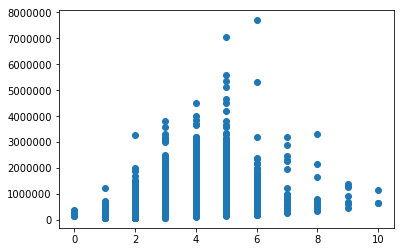

In [39]:
plt.scatter(train_data['bedrooms'],train_data['price'])

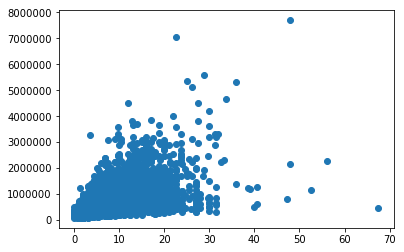

In [40]:
plt.scatter(train_data['bed_bath_rooms'],train_data['price'])

In [42]:
#Done